In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
import parent
import networks

In [2]:
from collections import OrderedDict
import torch.nn.functional as F
from mermaidlite import compute_warped_image_multiNC, identity_map_multiN
import torch
import random
import inverseConsistentNet
import networks
import network_wrappers
import data
import numpy as np
import matplotlib.pyplot as plt

In [3]:
r_ds = torch.load("/playpen/tgreer/knees_real_train_set")
batched_ds = list(zip(r_ds[::3], r_ds[1::3], r_ds[2::3]))

In [4]:
BATCH_SIZE = 32
SCALE = 1  # 1 IS QUARTER RES, 2 IS HALF RES, 4 IS FULL RES
input_shape = [BATCH_SIZE, 1, 40 * SCALE, 96 * SCALE, 96 * SCALE]

GPUS = 4


phi = network_wrappers.FunctionFromVectorField(
    networks.tallUNet(unet=networks.UNet2ChunkyMiddle, dimension=3)
)
psi = network_wrappers.FunctionFromVectorField(
    networks.tallUNet2(dimension=3)
)

net = inverseConsistentNet.InverseConsistentNet(
    network_wrappers.DoubleNet(phi, psi),
    lambda x, y: torch.mean((x - y) ** 2),
    100,
)

network_wrappers.assignIdentityMap(net, input_shape)

/playpen-raid1/tgreer/InverseConsistency/networks.py:483: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np.array([[2, 16, 32, 64, 256, 512], [16, 32, 64, 128, 256]]),


In [5]:
def adjust_batch_size(model, size):
    shape = model.input_shape
    shape[0] = size
    network_wrappers.assignIdentityMap(model, shape)

adjust_batch_size(net, 32)

trained_weights = torch.load("../results/double_deformable_knee3/knee_aligner_resi_net8400")


In [6]:
net.load_state_dict(trained_weights)

<All keys matched successfully>

In [7]:
adjust_batch_size(net, 3)
net.cuda()
net.eval()

InverseConsistentNet(
  (regis_net): DoubleNet(
    (netPsi): FunctionFromVectorField(
      (net): UNet2(
        (downConvs): ModuleList(
          (0): Conv3d(2, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (1): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (2): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (3): Conv3d(64, 256, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
          (4): Conv3d(256, 512, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
        )
        (upConvs): ModuleList(
          (0): ConvTranspose3d(48, 16, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
          (1): ConvTranspose3d(96, 32, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
          (2): ConvTranspose3d(192, 64, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
          (3): ConvTranspose3d(512, 128, kernel_size=(4, 4, 4), strid

In [8]:
dices = []
for x in batched_ds:
    x = list(zip(*x))
    x = [torch.cat(r, 0).cuda().float() for r in x]
    fixed_image, fixed_cartilage = x[0], x[2]
    moving_image, moving_cartilage = x[1], x[3]
    
    net(moving_image, fixed_image)
    fat_phi = torch.nn.Upsample(size=moving_cartilage.size()[2:], mode="trilinear")(net.phi_AB(net.identityMap)[:, :3])
    sz = np.array(fat_phi.size())
    spacing = 1./(sz[2::]-1) 
    warped_moving_cartilage = compute_warped_image_multiNC(moving_cartilage.float(), fat_phi, spacing, 1)
    wmb = warped_moving_cartilage > .5
    fb = fixed_cartilage > .5
    intersection = wmb * fb
    d = 2 * torch.sum(intersection).float() / (torch.sum(wmb) + torch.sum(fb))
    print(d)
    dices.append(d)
dd = np.mean([d.item() for d in dices])
print(dd)

/playpen-raid1/tgreer/anaconda3/envs/mermaid5/lib/python3.7/site-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=trilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


tensor(0.6541, device='cuda:0')
tensor(0.5299, device='cuda:0')
tensor(0.6316, device='cuda:0')
tensor(0.6701, device='cuda:0')
tensor(0.6120, device='cuda:0')
tensor(0.5788, device='cuda:0')
tensor(0.5667, device='cuda:0')
tensor(0.4188, device='cuda:0')
tensor(0.6007, device='cuda:0')
tensor(0.6015, device='cuda:0')
tensor(0.5776, device='cuda:0')
tensor(0.5825, device='cuda:0')
tensor(0.5346, device='cuda:0')
tensor(0.6174, device='cuda:0')
tensor(0.4899, device='cuda:0')
tensor(0.6088, device='cuda:0')
tensor(0.5056, device='cuda:0')
tensor(0.5841, device='cuda:0')
tensor(0.5413, device='cuda:0')
tensor(0.5941, device='cuda:0')
tensor(0.6355, device='cuda:0')
tensor(0.6102, device='cuda:0')
tensor(0.5899, device='cuda:0')
tensor(0.6591, device='cuda:0')
tensor(0.6075, device='cuda:0')
tensor(0.6032, device='cuda:0')
tensor(0.6151, device='cuda:0')
tensor(0.5033, device='cuda:0')
tensor(0.5540, device='cuda:0')
tensor(0.5715, device='cuda:0')
tensor(0.6288, device='cuda:0')
tensor(0

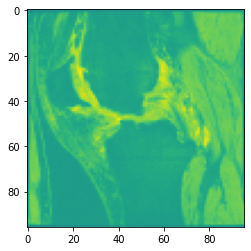

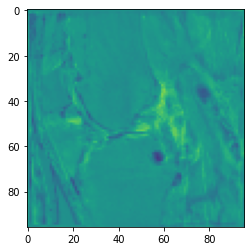

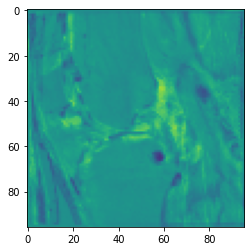

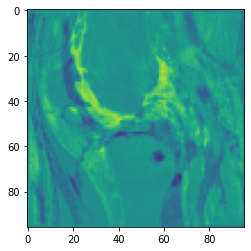

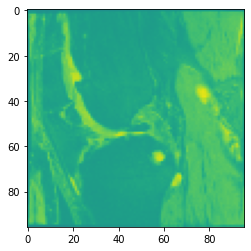

In [11]:
if not("N" in locals()):
    N = 0
N += 1
N %= 3
#plt.imshow(fixed_image[N, 0, 10].cpu() - net.warped_image_A[N, 0, 10].cpu().detach())
#plt.show()

def imshow(x):
    plt.imshow(x.cpu().detach(), vmin=-1, vmax=1)

imshow(fixed_image[N, 0, 20])
plt.show()
imshow(net.warped_image_B[N, 0, 20].cpu().detach() - moving_image[N, 0, 20].cpu().detach())
plt.show()
imshow(net.regis_net.x_comp_phi[N, 0, 20].cpu().detach() - moving_image[N, 0, 20].cpu().detach())
plt.show()
imshow((fixed_image - moving_image)[N, 0, 20].cpu().detach())
plt.show()
imshow(moving_image[N, 0, 20].cpu().detach())
plt.show()

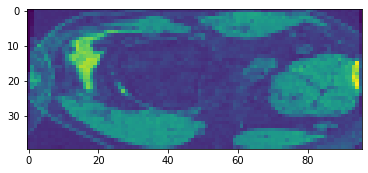

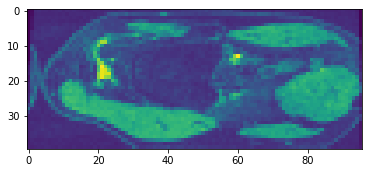

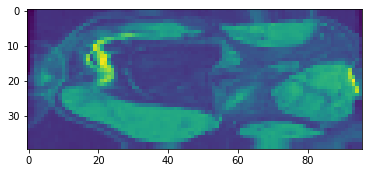

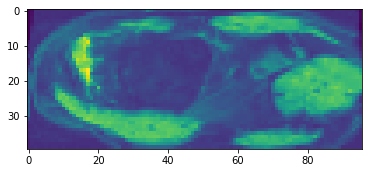

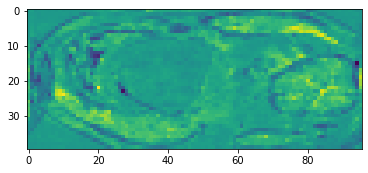

In [12]:
import matplotlib.pyplot as plt
plt.imshow(moving_image[0, 0, :, 10].cpu())
plt.show()
plt.imshow(fixed_image[0, 0, :, 10].cpu())
plt.show()
plt.imshow(net.warped_image_A[0, 0, :, 10].cpu().detach())
plt.show()
plt.imshow(net.warped_image_B[0, 0, :, 10].cpu().detach())
plt.show()

plt.imshow(net.warped_image_B[0, 0, :, 10].cpu().detach() - moving_image[0, 0, :, 10].cpu())

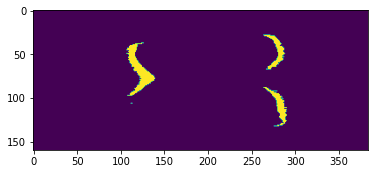

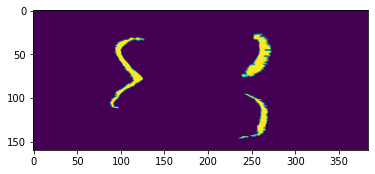

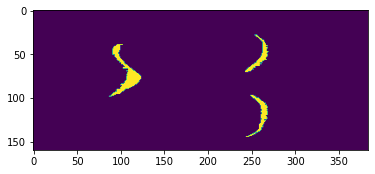

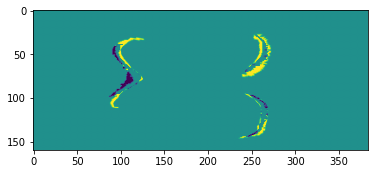

In [13]:
N +=1
N %= 3
S = 40
plt.imshow(moving_cartilage[N, 0, :, S * 4].cpu())
plt.show() 
plt.imshow(warped_moving_cartilage[N, 0, :, S * 4].detach().cpu())
plt.show()

plt.imshow(fixed_cartilage[N, 0, :, S * 4].cpu())
plt.show()

plt.imshow((warped_moving_cartilage[N, 0, :, S * 4].detach().cpu() - fixed_cartilage[N, 0, :, S * 4].cpu()))
plt.show()

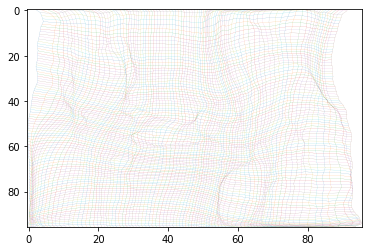

In [14]:
import visualize
N = (N + 1)% 3
visualize.show_as_grid(net.phi_BA_vectorfield[N, [1, 2], 20])

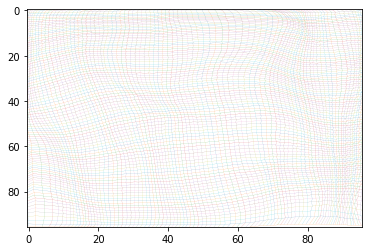

In [15]:
phi = net.phi_AB.__closure__[0]
some_vectorfield = phi.cell_contents.__closure__[1].cell_contents + net.identityMap
visualize.show_as_grid(some_vectorfield[2, [1, 2], 20])

In [16]:
net.phi_AB.__closure__[0].cell_contents

<function network_wrappers.FunctionFromVectorField.forward.<locals>.ret(input_)>

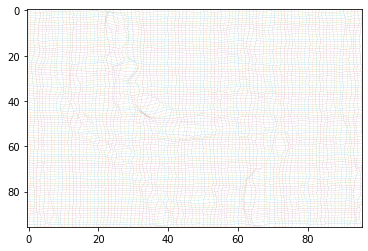

In [17]:
visualize.show_as_grid(net.phi_AB(net.phi_BA(net.identityMap))[1, [1, 2], 20])

In [128]:
type(net.regisNet.netPhi)

ModuleAttributeError: 'InverseConsistentNet' object has no attribute 'regisNet'

In [129]:
net.lmbda

100

In [130]:
trained_weights.keys()

odict_keys(['identityMap', 'regis_net.identityMap', 'regis_net.netPsi.identityMap', 'regis_net.netPsi.net.identityMap', 'regis_net.netPsi.net.downConvs.0.weight', 'regis_net.netPsi.net.downConvs.0.bias', 'regis_net.netPsi.net.downConvs.1.weight', 'regis_net.netPsi.net.downConvs.1.bias', 'regis_net.netPsi.net.downConvs.2.weight', 'regis_net.netPsi.net.downConvs.2.bias', 'regis_net.netPsi.net.downConvs.3.weight', 'regis_net.netPsi.net.downConvs.3.bias', 'regis_net.netPsi.net.downConvs.4.weight', 'regis_net.netPsi.net.downConvs.4.bias', 'regis_net.netPsi.net.upConvs.0.weight', 'regis_net.netPsi.net.upConvs.0.bias', 'regis_net.netPsi.net.upConvs.1.weight', 'regis_net.netPsi.net.upConvs.1.bias', 'regis_net.netPsi.net.upConvs.2.weight', 'regis_net.netPsi.net.upConvs.2.bias', 'regis_net.netPsi.net.upConvs.3.weight', 'regis_net.netPsi.net.upConvs.3.bias', 'regis_net.netPsi.net.upConvs.4.weight', 'regis_net.netPsi.net.upConvs.4.bias', 'regis_net.netPsi.net.batchNorms.0.weight', 'regis_net.netPs

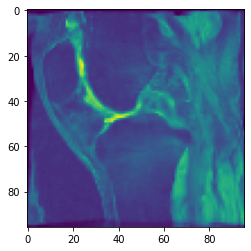

In [162]:
plt.imshow(net.warped_image_B[0, 0, 20].cpu().detach())